In [17]:
from lxml import html
import re
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib


page = requests.get('https://bcs-express.ru/dividednyj-kalendar')
tree = html.fromstring(page.content)

In [317]:
def cleanData(text):
    text = re.sub(r'[$IV]+', '', text)
    text = re.sub(r'[,]+', '.', text)
    text = re.sub(r'[\s]+', ' ', text)
    return text.strip()

def cleanDataDate(text):
    text = re.search(r'\.([\d]{2,2})\.', text)
    text = text.group(1) if not (text is None) else '-'
    return text

def cleanDataName(text):
    text = re.sub(r'кв\.|нераспр\.|\bприбыль|мес\.', '', text)
    text = re.sub(r'[\d]{2,4}', '', text)
    text = re.sub(r'\(.*\)', '', text)
    return text.strip()

namesXML = tree.xpath('//div[@class="dividends-table__row _item"]//div[@class="dividends-table__cell _title _toggle js-div-table-toggle"]/text()')
datesXML = tree.xpath('//div[@class="dividends-table__row _item"]//div[@class="dividends-table__cell _close-date"]/span[@class="dividends-table__value"]/text()')
valueXML = tree.xpath('//div[@class="dividends-table__item js-div-table-item"]/div[@class="dividends-table__row _item"]/div[@class="dividends-table__cell _value"]/text()')
priceXML = tree.xpath('//div[@class="dividends-table__row _item"]//div[@class="dividends-table__cell _price"]//span[@class="dividends-table__value"]/text()')

names = [cleanDataName(cleanData(str(s))) for s in namesXML]
dates = [cleanData(str(s)) for s in datesXML]
value = [float(cleanData(str(s))) for s in valueXML]
price = [float(cleanData(str(s))) for s in priceXML]

month=[cleanDataDate(str) for str in dates]


In [324]:
my_dict ={'names':names,
          'dates':dates,
          'month':month,
          'value':value,
          'price':price
        }

#print(ttt)
df = pd.DataFrame (my_dict, columns = ['names','dates','month','value','price'])

#df.to_csv("test.csv",encoding='utf-8-sig')

In [327]:
mySharesArr = ['Магнит ао','Сбербанк ао',
               'Интер РАО ао','ВТБ ао',
               'Газпром ао','НЛМК ао','Новатэк ао',
               'Северсталь ао','Татнефть ао'
              ]
mySharesCnt = [750,1000,
               30000,25000000,
               2000,3500,200,
               400,940
              ]
enumerateShares = enumerate(mySharesCnt)

mySharesIsPresent = np.zeros(len(df.names))

In [328]:
isSharesPresent = [max ([myShare in str  for myShare in mySharesArr] )for str in df.names.values]
mySharesIsPresent[isSharesPresent]=1
mySharesCntArr = [mySharesCnt[mySharesArr.index(share)] if share in mySharesArr else 0 for share in df.names.values]

In [329]:
df['portfolio'] = mySharesIsPresent
df['shareCnt'] = mySharesCntArr
df['res'] = df.shareCnt.values * df.value.values

In [330]:
df

,names,dates,month,value,price,portfolio,shareCnt,res
0,Норильский Никель ао,25.05.2020,05,557.200000,20104.00000,0.0,0,0.00000
1,TCS Group,29.05.2020,05,0.140000,1049.60000,0.0,0,0.00000
2,X5 Retail,29.05.2020,05,110.470000,2216.00000,0.0,0,0.00000
3,ФСК ЕЭС ао,29.05.2020,05,0.009494,0.18694,0.0,0,0.00000
4,Интер РАО ао,01.06.2020,06,0.196193,4.65600,1.0,30000,5885.77587
...,...,...,...,...,...,...,...,...
75,ФосАгро ао,04.02.2020,02,48.000000,2469.00000,0.0,0,0.00000
76,ФСК ЕЭС ао 9,13.01.2020,01,0.008810,0.21230,0.0,0,0.00000
77,Черкизово ао,07.04.2020,04,60.920000,1995.00000,0.0,0,0.00000
78,ЧТПЗ ао 9,09.01.2020,01,5.450000,205.00000,0.0,0,0.00000


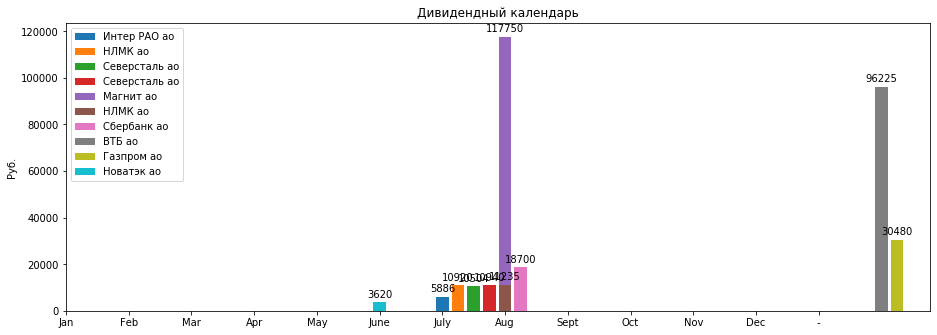

In [331]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


monthArr = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec','-']
x = np.arange(len(monthArr)) 

fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
cntSharePerMnth = {}
rectArr=[]
namesArr=[]

for index,row in df.iterrows():
    if(row['res'] == 0):
        continue
        
    monthInd = int(row['month']) if not row['month'] == '-' else 13
    sharePrice = row['res']
    shareName = row['names']
    
    cntSharePerMnth[monthInd] = cntSharePerMnth[monthInd] + 1 if not cntSharePerMnth.get(monthInd) is None else 0
    shift = cntSharePerMnth.get(monthInd) if not cntSharePerMnth.get(monthInd) is None else -1
    
    rect = ax.bar(monthInd + 0.25*shift, round(sharePrice), width = 0.2)
    rectArr.append(rect)
    namesArr.append(shareName)
    autolabel(rect)


ax.set_xticks(x)
ax.set_xticklabels(monthArr)
ax.legend(rectArr,namesArr)

ax.set_ylabel('Руб.')
ax.set_title('Дивидендный календарь')


plt.show()

In [334]:
totalSum = round(np.sum(df.res.values),2)
totalSumWoTax = round(np.sum(df.res.values) * 0.87,2)
totalPerMonth = round(totalSumWoTax/12)

print("Portfolio div Total: "  + str(totalSum))
print("Portfolio div Wo Tax: "  + str(totalSumWoTax))
print("Per month income: " + str(totalPerMonth))

Portfolio div Total: 316259.78
Portfolio div Wo Tax: 275146.01
Per month income: 22929.0


In [333]:
df.to_csv("test.csv",encoding='utf-8-sig')

In [339]:
df.names.values

array(['Норильский Никель ао', 'TCS Group', 'X5 Retail', 'ФСК ЕЭС ао',
       'Интер РАО ао', 'ФосАгро ао', 'Распадская ао', 'Акрон ао',
       'МОЭСК ао', 'МРСК Волги ао', 'МРСК Северо-Запада ао',
       'МРСК Урала ао', 'НЛМК ао', 'Саратовский НПЗ ап',
       'Белуга Групп ао', 'Ленэнерго ао', 'Ленэнерго ап',
       'Кубаньэнерго ао', 'Роснефть ао', 'Россети ао', 'Россети ап',
       'ЧТПЗ ао', 'Северсталь ао', 'Северсталь ао', 'Пермэнергосбыт ао',
       'Пермэнергосбыт ап', 'ТРК ап', 'Магнит ао', 'Юнипро ао',
       'Газпром нефть ао', 'Татнефть ап', 'Башнефть ао', 'Башнефть ап',
       'ФосАгро ао', 'МТС ао', 'Энел Россия ао', 'Алроса ао', 'НЛМК ао',
       'Сбербанк ао', 'Сбербанк ап', 'ВТБ ао', 'Газпром ао', 'Лукойл ао',
       'МЕЧЕЛ ап', 'ММК ао', 'ОГК-2 ао', 'Полюс ао', 'Ростелеком ао',
       'Ростелеком ап', 'Сургутнефтегаз ао', 'Сургутнефтегаз ап',
       'Татнефть ао', 'Qiwi', 'TCS Group', 'Акрон ао', 'ЛСР ао',
       'Магнит ао 9', 'ММК ао 9', 'Московская Биржа ао', 'МОЭ